<a id = 'toc'></a>
# Table of Contents

- ### [Preprocessing-Light](#preprocessing_light)
- ### [Preprocessing-Pandas](#preprocessing_pandas)
- ### [Word vectorization](#word_vectorization)
- ### [Example 1](#example_1)
- ### [Gensim](#gensim)
- ### [Text Classification](#text_classification)
- ### [Example 2: ChatBotPractice](#example_2)

<a id = 'preprocessing_light'></a>
# Preprocessing-Light

---
## Decoding
converting a sequence of bytes into a sequence of characters.

- **Unpacking** \
*.plain/.zip/.gz/...*
- **Encoding** \
*ASCII/utf-8/Windows-1251/...*
- **Format** \
*csv/xml/json/doc/...*

---

## Split into tokens
splitting a sequence of characters into parts (tokens), possibly excluding some characters from consideration.
Naive approach: split the string with spaces and throw out punctuation marks.

**Problems:**  
* example@example.com, 127.0.0.1
* С++, C#
* York University vs New York University
* Language dependency (“Lebensversicherungsgesellschaftsangestellter”, “l’amour”)

Alternative: n-grams

---

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer

sequence = 'The quick brown fox jumps, and jumps over the lazy dog'

tokenizer = RegexpTokenizer('\w+|[^\w\s]+')
for token in tokenizer.tokenize(sequence):
    print(token)

The
quick
brown
fox
jumps
,
and
jumps
over
the
lazy
dog


---
## Stop words
the most frequent words in the language that do not contain any information about the content of the text

**Problem**: To be or not to be.

---

In [3]:
from nltk.corpus import stopwords

print(' '.join(stopwords.words('english')[1:20]))

me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his


---
## Normalization
Bringing tokens to a single form in order to get rid of superficial differences in spelling

**Approaches:**
* formulate a set of rules by which the token is transformed \
New-Yorker → new-yorker → newyorker → newyork
* explicity store connections betweens tokens (WordNet - Princeton) \
car → auto, Window 6 → window
машина → автомобиль, Windows 6→ window

---

In [4]:
word = 'New-Yorker'

word_1 = word.lower()

import re
word_2 = re.sub(r'\W', '', word_1, flags = re.U)

word_3 = re.sub(r'er', '', word_2, flags = re.U)

print(f'{word} → {word_1} → {word_2} → {word_3}')

New-Yorker → new-yorker → newyorker → newyork


---
## Stemming and Lemmatization
**Stemming** is a process that stems or removes last few characters from a word, often leading to incorrect meanings and spelling.
**Lemmatization** considers the conext and converts the word to its meaningful base form, which is called *Lemma*.

**Example:**
* Steeming
Caring → Car
* Lemmatization
Caring → Care

---

## Stemming

In [5]:
from nltk.stem.snowball import PorterStemmer
from nltk.stem.snowball import EnglishStemmer

p_stemmer = PorterStemmer()
print(f'[Porter Stemmer]: {p_stemmer.stem("New-Yorker")}')
print(f'[Porter Stemmer]: {p_stemmer.stem("Tokenization")}')

eng_stemmer = EnglishStemmer()
print(f'[English Stemmer]: {eng_stemmer.stem("Perfection")}')
print(f'[English Stemmer]: {eng_stemmer.stem("Difference")}')

[Porter Stemmer]: new-york
[Porter Stemmer]: token
[English Stemmer]: perfect
[English Stemmer]: differ


## Lemmatization

In [6]:
import pymorphy2

morph = pymorphy2.MorphAnalyzer()
print(f'[pymorphy2]: {morph.parse("New-Yorker")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Tokenization")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Perfection")[0].normal_form}')
print(f'[pymorphy2]: {morph.parse("Difference")[0].normal_form}')

[pymorphy2]: new-yorker
[pymorphy2]: tokenization
[pymorphy2]: perfection
[pymorphy2]: difference


---

## Heap's Law (Herdan's law)
An empirical regularity in linguistics that describes the distribution of the number of unique words in a document (or set of documents) as a function of it's length.


$ M = kT^{\beta}$
- $M$ - dictionary size
- $T$ - word count
- $30 \leq k \leq 100, b \approx 0.5$

---

[UP](#toc)

<a id = 'preprocessing_pandas'></a>
# Preprocessing-Pandas

#### Using methods

In [8]:
import pandas as pd

sequences_list = pd.Series(['Our mother washed - The Dishes', 'The countdown, Is over'], dtype = "string")
print(f'[BEFORE]: {sequences_list[0]}')

sequences_list = sequences_list.str.lower()
sequences_list = sequences_list.str.strip()
#sequences_list = sequences_list.str.split(' ', expand = True)
sequences_list = sequences_list.str.split(' ')
print(f'[AFTER]: {sequences_list[0]}')

[BEFORE]: Our mother washed - The Dishes
[AFTER]: ['our', 'mother', 'washed', '-', 'the', 'dishes']


#### Using functions

In [9]:
import string
import pymorphy2

morpher = pymorphy2.MorphAnalyzer()
sw = ['dishes']

def preprocess_txt(line):
    exclude = set(string.punctuation)
    spls = ''.join(i for i in line.strip() if i not in exclude).split()
    spls = [morpher.parse(i.lower())[0].normal_form for i in spls]
    spls = [i for i in spls if i not in sw and i != '']
    return spls
    
sequences_list = pd.Series(['Our mother washed - The Dishes', 'The countdown, Is over'], dtype = "string")
print(f'[BEFORE]: {sequences_list[0]}')
sequences_list = sequences_list.apply(lambda x: preprocess_txt(x))
print(f'[AFTER]: {sequences_list[0]}')

[BEFORE]: Our mother washed - The Dishes
[AFTER]: ['our', 'mother', 'washed', 'the']


[UP](#toc)

<a id = 'word_vectorization'></a>
# Word vectorization

### Bag-of-Words

In [13]:
documents = ["I like this movie, it's funny.", "I hate this movie."
             , "This was awesome! I like it.", "Nice one. I love it."]

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

count_vectorizer = CountVectorizer()
bag_of_words = count_vectorizer.fit_transform(documents)

count_vectorizer.fit_transform(documents)

feature_names = count_vectorizer.get_feature_names_out()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

,awesome,funny,hate,it,like,love,movie,nice,one,this,was
0,0,1,0,1,1,0,1,0,0,1,0
1,0,0,1,0,0,0,1,0,0,1,0
2,1,0,0,1,1,0,0,0,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0


### N-gramm

In [14]:
from nltk.util import ngrams

text = "I like this movie, it's funny. I hate this movie. This was awesome! I like it. Nice one. I love it."

tokenized = text.split()
bigrams = ngrams(tokenized, 2)
for i in bigrams:
    print(i)

('I', 'like')
('like', 'this')
('this', 'movie,')
('movie,', "it's")
("it's", 'funny.')
('funny.', 'I')
('I', 'hate')
('hate', 'this')
('this', 'movie.')
('movie.', 'This')
('This', 'was')
('was', 'awesome!')
('awesome!', 'I')
('I', 'like')
('like', 'it.')
('it.', 'Nice')
('Nice', 'one.')
('one.', 'I')
('I', 'love')
('love', 'it.')


### TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

document = ["I like this movie, it's funny.", "I hate this movie."
            , "This was awesome! I like it.", "Nice one. I love it."]
tfidf_vectorizer = TfidfVectorizer()
values = tfidf_vectorizer.fit_transform(document)

feature_name = tfidf_vectorizer.get_feature_names_out()
pd.DataFrame(values.toarray(), columns = feature_names)

,awesome,funny,hate,it,like,love,movie,nice,one,this,was
0,0.000000,0.571848,0.000000,0.365003,0.450852,0.000000,0.450852,0.000000,0.000000,0.365003,0.000000
1,0.000000,0.000000,0.702035,0.000000,0.000000,0.000000,0.553492,0.000000,0.000000,0.448100,0.000000
2,0.539445,0.000000,0.000000,0.344321,0.425305,0.000000,0.000000,0.000000,0.000000,0.344321,0.539445
3,0.000000,0.000000,0.000000,0.345783,0.000000,0.541736,0.000000,0.541736,0.541736,0.000000,0.000000


### Hashing

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer

document = ["I like this movie, it's funny.", "I hate this movie."
            , "This was awesome! I like it.", "Nice one. I love it."]

vectorizer = HashingVectorizer()
values = vectorizer.fit_transform(document)

pd.DataFrame(values.toarray())

,0,1,2,3,4,5,6,7,8,9,...,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574,1048575
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[UP](#toc)

<a id = 'example_1'></a>
# Example 1

In [2]:
import numpy as np
import matplotlib.pyplot
%matplotlib inline

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [3]:
dataset = datasets.load_dataset('imdb'
                                , split = 'train'
                                , download_mode = 'force_redownload')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
df = dataset
df = datasets.load_dataset('imdb')

In [5]:
df

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

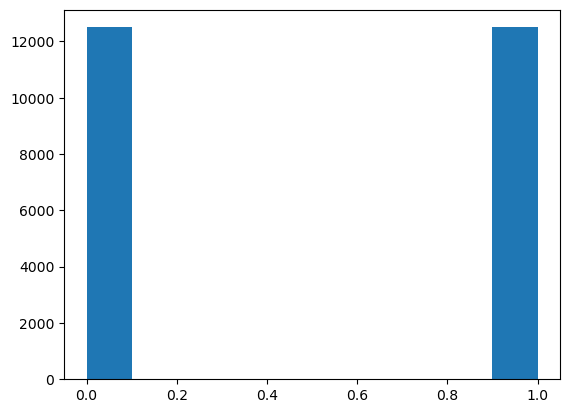

In [6]:
import matplotlib.pyplot as plt

train_labels = [i['label'] for i in df['train']]
plt.hist(train_labels)
plt.show()

### Classification using Linear Models

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer(max_features = 25000)
values = vectorizer.fit_transform(df['train']['text'])

feature_names = vectorizer.get_feature_names_out()
pd.DataFrame(values.toarray(), columns = feature_names)

,00,000,007,00s,01,02,03,04,05,06,...,zooming,zooms,zorak,zorro,zp,zu,zucker,zulu,zuniga,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
vectorizer = TfidfVectorizer(max_features = 25000)
vectorizer = vectorizer.fit(df['train']['text'])

x_train = vectorizer.transform(df['train']['text'])
y_train = np.array(df['train']['label'])

x_test = vectorizer.transform(df['test']['text'])
y_test = np.array(df['test']['label'])

x_train, y_train

(<25000x25000 sparse matrix of type '<class 'numpy.float64'>'
 	with 3355130 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 1, 1, 1]))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

model = LogisticRegression()
model = model.fit(x_train, y_train)

log_pred = model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, log_pred))
acc = accuracy_score(y_test, log_pred)

print(f'[RMSE]: {rmse:.2f}, [ACC]: {acc:.2f}')

[RMSE]: 0.34, [ACC]: 0.88


#### Testing model prediction

In [10]:
positive_comment = 'This movie is awesome!'
vec = vectorizer.transform([positive_comment])
positive_pred = model.predict(vec)

negative_comment = 'This movie is awful!'
vec = vectorizer.transform([negative_comment])
negative_pred = model.predict(vec)

print(f'[PositiveComment]: {positive_pred[0]}, \
[NegativeComment]: {negative_pred[0]}')

[PositiveComment]: 1, [NegativeComment]: 0


[UP](#toc)

<a id = 'gensim'></a>
# Gensim

In [4]:
import gensim.downloader as api

word_vectors = api.load('glove-wiki-gigaword-100')

result = word_vectors.most_similar(positive = ['woman', 'king'], negative = ['man'])
print(word_vectors.doesnt_match('breakfast dinner cereal lunch'.split()))

similarity = word_vectors.similarity('woman', 'man')
print(f'{similarity:.2f}')

<a id = 'text_classification'></a>
# Text Classification

- Naive Bayes
- SVM
- LogisticRegression
- RandomForestClassifier
- XGBoostClassifier

In [136]:
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
#from sklearn import naive_bayes, linear_model, ensemble, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from tqdm import tqdm_notebook
%pylab inline

from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Leo\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [130]:
df = pd.read_excel('Upload/14.7.xls')

In [131]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [109]:
exclude = set(punctuation)
sw = set(get_stop_words('ru'))
morpher = MorphAnalyzer()

In [110]:
df_sample = df.iloc[:5000]

In [111]:
def preprocess_text(line):
    splt = str(line)
    splt = ''.join(i for i in splt if i not in exclude)
    splt = splt.lower()
    splt = re.sub('не\s', 'не', splt)
    splt = [morpher.parse(word)[0].normal_form for word in splt.split() if word not in exclude]
    return ' '.join(splt)

#df_sample['Content'].apply(lambda x: preprocess_text(x))

In [112]:
df_sample['text'] = df_sample['Content'].apply(preprocess_text)
df_sample_rating = df_sample[df_sample['Rating'] != 3]
df_sample_rating['target'] = df_sample_rating['Rating'] > 3

C:\Users\Leo\AppData\Local\Temp\ipykernel_12192\725875120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['text'] = df_sample['Content'].apply(preprocess_text)
C:\Users\Leo\AppData\Local\Temp\ipykernel_12192\725875120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_rating['target'] = df_sample_rating['Rating'] > 3


In [134]:
x_train, x_test, train_y, test_y = train_test_split(df_sample_rating['text']
                                                                    , df_sample_rating['target'])

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_y)
y_test = encoder.fit_transform(test_y)

In [114]:
x_train.shape, x_test.shape

((3585,), (1195,))

In [115]:
count_vectorizer = CountVectorizer().fit(x_train.values)
x_train_count = count_vectorizer.transform(x_train)
x_test_count = count_vectorizer.transform(x_test)

tfidf_vectorizer = TfidfVectorizer().fit(x_train.values)
x_train_tfidf = tfidf_vectorizer.transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range = (1, 3)).fit(x_train.values)
x_train_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_train)
x_test_tfidf_ngram = tfidf_vectorizer_ngram.transform(x_test)

In [117]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net = False):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis = -1)
        
    return accuracy_score(predictions, y_test)

## Naive Bayes

In [119]:
acc_nb_count = train_model(naive_bayes.MultinomialNB(), x_train_count, y_train, x_test_count)
acc_nb_tfidf = train_model(naive_bayes.MultinomialNB(), x_train_tfidf, y_train, x_test_tfidf)
acc_nb_tfidf_ngram = train_model(naive_bayes.MultinomialNB(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_nb_count:.2f}, [TF-IDF]: {acc_nb_tfidf:.2f}, [TF-IDF N-Gram]: {acc_nb_tfidf_ngram:.2f}')

[Count]: 0.93, [TF-IDF]: 0.89, [TF-IDF N-Gram]: 0.87


## Linear Classifier - Logistic Regression

In [121]:
acclrcount = train_model(LogisticRegression(), x_train_count, y_train, x_test_count)
acclrtfidf = train_model(LogisticRegression(), x_train_tfidf, y_train, x_test_tfidf)
acclrtfidf_ngram = train_model(LogisticRegression(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acclrcount:.2f}, [TF-IDF]: {acclrtfidf:.2f}, [TF-IDF N-Gram]: {acclrtfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


## SVM

In [122]:
acc_svm_count = train_model(svm.SVC(), x_train_count, y_train, x_test_count)
acc_svm_tfidf = train_model(svm.SVC(), x_train_tfidf, y_train, x_test_tfidf)
acc_svm_tfidf_ngram = train_model(svm.SVC(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_svm_count:.2f}, [TF-IDF]: {acc_svm_tfidf:.2f}, [TF-IDF N-Gram]: {acc_svm_tfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.91, [TF-IDF N-Gram]: 0.90


## Random Forest

In [124]:
clf = ensemble.RandomForestClassifier(n_estimators = 10000).fit(x_train_count, y_train)

In [125]:
acc_scores = []

for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):
    clf =  ensemble.RandomForestClassifier(n_estimators = i).fit(x_train_count, y_train)
    acc_scores.append(accuracy_score(clf.predict(x_test_count), y_test))
    
acc_rfc_count = np.mean(acc_scores)

C:\Users\Leo\AppData\Local\Temp\ipykernel_12192\4151042975.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([10, 30, 60, 100, 1000, 2000]):


  0%|          | 0/6 [00:00<?, ?it/s]

In [126]:
acc_rfc_tfidf = train_model(ensemble.RandomForestClassifier(), x_train_tfidf, y_train, x_test_tfidf)
acc_rfc_tfidf_ngram = train_model(ensemble.RandomForestClassifier(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_rfc_count:.2f}, [TF-IDF]: {acc_rfc_tfidf:.2f}, [TF-IDF N-Gram]: {acc_rfc_tfidf_ngram:.2f}')

[Count]: 0.90, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


## Boosting Model

In [128]:
acc_xgb_count = train_model(XGBClassifier(), x_train_count, y_train, x_test_count)
acc_xgb_tfidf = train_model(XGBClassifier(), x_train_tfidf, y_train, x_test_tfidf)
acc_xgb_tfidf_ngram = train_model(XGBClassifier(), x_train_tfidf_ngram, y_train, x_test_tfidf_ngram)

print(f'[Count]: {acc_xgb_count:.2f}, [TF-IDF]: {acc_xgb_tfidf:.2f}, [TF-IDF N-Gram]: {acc_xgb_tfidf_ngram:.2f}')

[Count]: 0.91, [TF-IDF]: 0.90, [TF-IDF N-Gram]: 0.90


<a id = 'example_2'></a>
# Example 2: ChatBotPractice

In [1]:
import string
import os 
import annoy
import codecs

from stop_words import get_stop_words
from gensim.models import Word2Vec
from pymorphy2 import MorphAnalyzer

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [28]:
start = 0
end = 1000

question = None
written = False

with codecs.open('Upload/prepared_answers.txt', 'w', 'utf-8') as f_out:
    with codecs.open('Upload/14.8.txt', 'r', 'utf-8') as f_in:
        for line in tqdm(f_in):
            start += 1
            if start > end:
                break
                
            if line.startswith('---'):
                written = False
            if not written and question is not None:
                f_out.write(question.replace('\t', ' ').strip() + '\t' + line.replace('\t',' '))
            if not written:
                question = line.strip()
                continue
                
            

0it [00:00, ?it/s]

In [ ]:
question = None
written = False

#Мы идем по всем записям, берем первую строку как вопрос
# и после знака --- находим ответ
with codecs.open("prepared_answers.txt","w", "utf-8") as fout:
    with codecs.open("Otvety.txt", "r", "utf-8") as fin:
        for line in tqdm(fin):
            if line.startswith("---"):
                written = False
                continue
            if not written and question is not None:
                fout.write(question.replace("\t", " ").strip() + "\t" + line.replace("\t", " "))
                written = True
                question = None
                continue
            if not written:
                question = line.strip()
                continue

<a id = 'kmeans_inertia'></a>
<left>
<div style="color:white;
           display:fill;
           border: 0px;
           border-bottom: 2px solid #AAA;
           font-size:80%;
           letter-spacing:0.5px">
<h2 style="padding: 10px;
           color:#212121;">Inertia
</h2>
</div>    
</left>